# 🕷️ MSN
This tool scrapes headlines from the Morocco World News website and allows you to download the results as a CSV file.
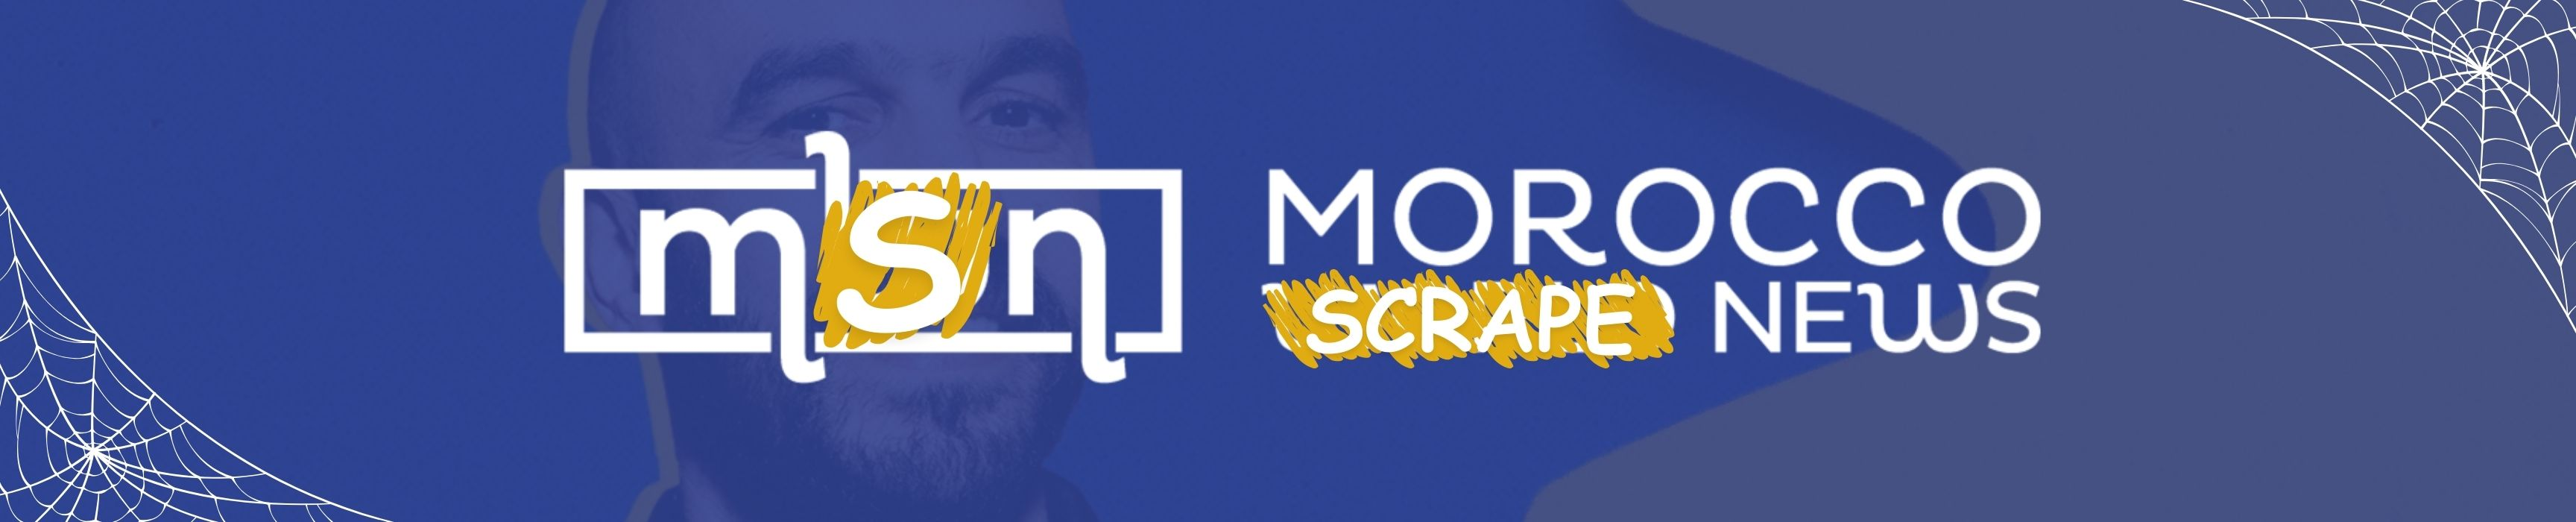

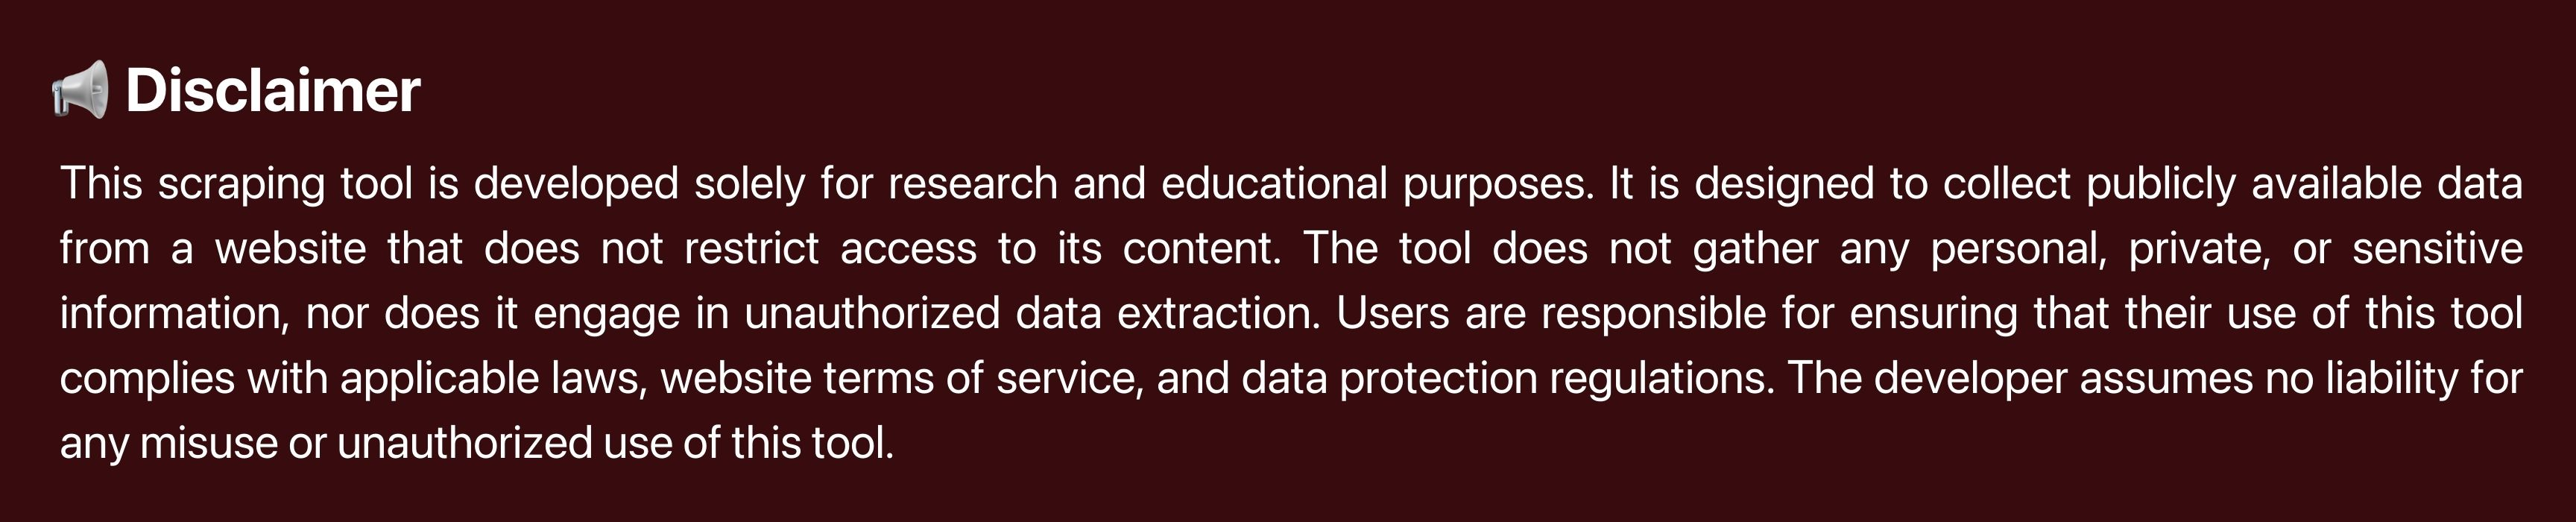
<img src="https://media1.tenor.com/m/eiTjwpZZKr0AAAAC/you-wouldn%27t-steal-a-car-steal.gif" width="150" />


In [ ]:
# @title ↙️ (Step 1) Click on the play button to start.
!pip install -q selenium webdriver_manager beautifulsoup4 pandas tqdm ipywidgets
!apt-get update > /dev/null 2>&1 && apt-get install -y wget > /dev/null 2>&1
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb > /dev/null 2>&1
!dpkg -i google-chrome-stable_current_amd64.deb > /dev/null 2>&1 || apt-get -f install -y > /dev/null 2>&1

print("Setup complete ✅. You can now proceed to Step 2.")

In [ ]:
# @title ↙️ (Step 2) Wait for Step 1 to finish then click this play button again.
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import pandas as pd
from tqdm.notebook import tqdm
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import base64
from io import StringIO
from datetime import datetime

def scrape_mwn(category, num_titles=5):
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3')

    url = f'https://www.moroccoworldnews.com/{category}'
    all_titles = []

    try:
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=chrome_options)
        driver.get(url)
        time.sleep(5)

        with tqdm(total=num_titles, desc="Scraping headlines") as pbar:
            while len(all_titles) < num_titles:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                soup = BeautifulSoup(driver.page_source, 'html.parser')

                first_big_title = [h1.a.text for h1 in soup.find_all('h1') if h1.get('data-v-a1527ed8') is not None]
                titles = [h3.a.text for h3 in soup.find_all('h3', class_='mb-4') if h3.get('data-v-779389b2') is not None]
                side_titles = [h5.a.text for h5 in soup.find_all('h5') if h5.get('data-v-a1527ed8') is not None]

                new_titles = first_big_title + side_titles + titles
                for title in new_titles:
                    if title not in all_titles:
                        all_titles.append(title)
                        pbar.update(1)
                    if len(all_titles) >= num_titles:
                        break

    except Exception as e:
        print(f"Error scraping {url}: {e}")
    finally:
        driver.quit()

    df = pd.DataFrame(all_titles[:num_titles], columns=['headline'])
    df['id'] = df.index + 1
    return df

def get_csv_download_link(df, num_headlines, category):
    current_time = datetime.now().strftime("%d_%b_%H_%M")
    filename = f"{num_headlines}_{category}_headlines_{current_time}.csv"
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()

    download_icon = '''
    <svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="currentColor" class="bi bi-download" viewBox="0 0 16 16">
      <path d="M.5 9.9a.5.5 0 0 1 .5.5v2.5a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1v-2.5a.5.5 0 0 1 1 0v2.5a2 2 0 0 1-2 2H2a2 2 0 0 1-2-2v-2.5a.5.5 0 0 1 .5-.5z"/>
      <path d="M7.646 11.854a.5.5 0 0 0 .708 0l3-3a.5.5 0 0 0-.708-.708L8.5 10.293V1.5a.5.5 0 0 0-1 0v8.793L5.354 8.146a.5.5 0 1 0-.708.708l3 3z"/>
    </svg>
    '''

    href = f'''
    <a href="data:text/csv;base64,{b64}" download="{filename}" target="_blank" style="text-decoration: none; color: #007bff; display: inline-flex; align-items: center; gap: 5px;">
      {download_icon}
      Download CSV
    </a>
    '''
    return href

def on_button_clicked(b):
    clear_output(wait=True)
    display(category_widget)
    display(num_headlines_widget)
    display(button)
    print(f"Scraping headlines from the {category_widget.value} category... This may take a few moments ⏳.")

    results = scrape_mwn(category_widget.value, num_headlines_widget.value)

    print(f"\nScraped {len(results)} headlines from the {category_widget.value} category:")
    display(results)

    download_link = get_csv_download_link(results, num_headlines_widget.value, category_widget.value)
    display(HTML(download_link))

categories = ['news-2', 'morocco-news', 'culture', 'politics', 'economy', 'opinion', 'lifestyle', 'society', 'education', 'gaza']

category_widget = widgets.Dropdown(
    options=categories,
    value='society',
    description='Category:',
    disabled=False,
)

num_headlines_widget = widgets.IntText(
    value=5,
    description='Nº of headlines:',
    disabled=False
)

button = widgets.Button(description="Start Scraping ⛏️")
button.on_click(on_button_clicked)

display(category_widget)
display(num_headlines_widget)
display(button)

<small> If you have feedback, have found a problem, or have a question, [let me know!](https://www.linkedin.com/in/yassine-lchgary)